In [6]:
import tempfile
import subprocess, pathlib, shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [7]:
exe="/scratch/spack-builds/atompaw-4.2.0.1/.spack-env/view/bin/atompaw"

In [19]:
element = 'Ce'
inputfile = """Ce  58                                                          
GGA-PBE  loggrid 2001 scalarrelativistic logderivrange -8 8 500  
6 5 5 4 0                                                       
5 2 1                                                           
4 3 1                                                           
0 0 0                                                           
c                                                               
c                                                               
c                                                               
c                                                               
v                                                               
v                                                               
c                                                               
c                                                               
c                                                               
v                                                               
c                                                               
c                                                               
v                                                               
v                                                               
3                                                               
2.335 1.9458 2.335 {rcore:.6f}               ! rpaw, rshape, rveff, rcore
n                                                               
y                                                               
2.0                                                             
n                                                               
y                                                               
2.0                                                             
n                                                               
y                                                               
2.0                                                             
n                                                               
VANDERBILT BESSELSHAPE                                          
4 0.0                                                           
2.295
2.295
2.295
2.295
2.295
2.295
2.295
2.295
ABINITOUT
default
PWSCFOUT                                                        
UPFDX  0.0125d0  UPFXMIN  -7.d0  UPFZMESH  58.0
END
0"""

In [3]:
def run_atompaw(inputfile, rc_core):
    with tempfile.TemporaryDirectory() as tmpdirname:
        inputfile = inputfile.format(rcore=rc_core)
        procout = subprocess.run(exe, input=inputfile.encode(), 
                                 cwd=tmpdirname, shell=True, check=True, capture_output=True)
        outputs = list(pathlib.Path(tmpdirname).glob('*UPF'))
        #return procout
        if len(outputs) != 1:
            #return procout
            return {'upf': None, 'rc_core': rc_core, 'upf_generated': False, 'input': inputfile}        
        with open(outputs[0], 'r') as upf:
            return {'upf': upf.read(), 'rc_core': rc_core, 'upf_generated': True, 'input': inputfile}

In [4]:
def bisection_search(F, a, b, tol=1e-2, maxstep=10):
    # must have initial a,b such that F(a) -> good, F(b) -> bad
    x = (a+b)/2
    diff = b-a
    fx = F(x)
    i = 0
    fa = F(a)
    if not fa['upf_generated']:
        raise Exception('invalid starting guess F(a) must producing a UPF file')
    # last working value
    fl = fa
    
    while diff > tol:
        if fx['upf_generated']:
            # worked, try to increase r_core
            a = x
            fl = fx
        else:
            # failed
            b = x
        x = (a+b)/2
        diff = b-a
        print('* tol %.2g' % diff)
        print('\t trying rc_core=', x)
        fx = F(x)        
        i = i+1
        if i >= maxstep:
            raise Exception('bisection search failed.')
    return a, fl

In [10]:
# search on rc_core = (1...3) to get an idea what to use as starting guess for the bisection search
ll = [(x, run_atompaw(inputfile, rc_core=x)) for x in np.linspace(1.2, 3, 30)]

In [17]:
rs, good = zip(*[(r, res['upf_generated']) for r, res in ll])

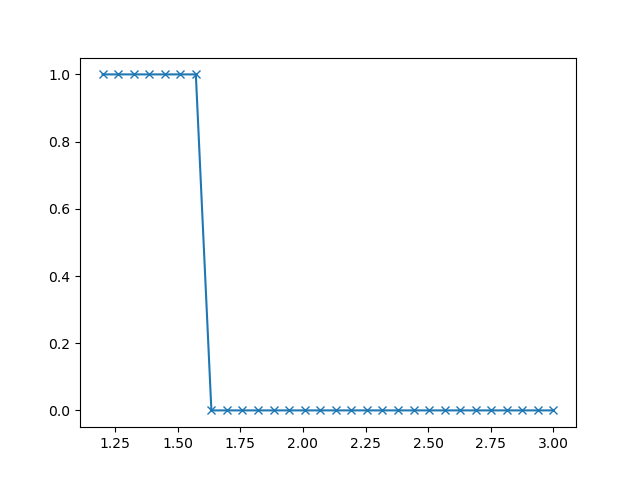

In [18]:
plt.plot(rs, good, '-x')

In [20]:
r, res = bisection_search(lambda r: run_atompaw(inputfile, r), 1.4, 2, tol=1e-6, maxstep=40)

* tol 0.3
	 trying rc_core= 1.5499999999999998
* tol 0.15
	 trying rc_core= 1.625
* tol 0.075
	 trying rc_core= 1.6625
* tol 0.038
	 trying rc_core= 1.64375
* tol 0.019
	 trying rc_core= 1.634375
* tol 0.0094
	 trying rc_core= 1.6296875
* tol 0.0047
	 trying rc_core= 1.6320312499999998
* tol 0.0023
	 trying rc_core= 1.630859375
* tol 0.0012
	 trying rc_core= 1.6314453125
* tol 0.00059
	 trying rc_core= 1.6317382812499999
* tol 0.00029
	 trying rc_core= 1.6318847656249997
* tol 0.00015
	 trying rc_core= 1.6319580078124998
* tol 7.3e-05
	 trying rc_core= 1.6319213867187496
* tol 3.7e-05
	 trying rc_core= 1.6319396972656248
* tol 1.8e-05
	 trying rc_core= 1.6319305419921872
* tol 9.2e-06
	 trying rc_core= 1.6319259643554684
* tol 4.6e-06
	 trying rc_core= 1.631928253173828
* tol 2.3e-06
	 trying rc_core= 1.6319293975830076
* tol 1.1e-06
	 trying rc_core= 1.6319299697875973
* tol 5.7e-07
	 trying rc_core= 1.6319302558898923


In [21]:
with open('{:s}.upf'.format(element), 'w') as file:
    file.write(res['upf'])
with open('{:s}-atompaw.in'.format(element), 'w') as file:
    file.write(res['input'])

In [104]:
r, files = zip(*ll)

In [1]:
plt.figure()
plt.plot(r, [i is None for i in files], '-x')

NameError: name 'plt' is not defined